In [144]:
#Loading important libraries
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tqdm
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, GlobalAveragePooling2D, Input, concatenate, BatchNormalization, Dropout
import keras_tuner as kt
from keras_tuner import RandomSearch
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score, confusion_matrix, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import pickle
from tensorflow.keras.optimizers import Adam, Adadelta
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer, MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [38]:
df = open('HousesInfo.txt','r')

In [39]:
df = df.readlines()

In [40]:
for index, line in enumerate(df):
      df[index] = line.strip()

In [41]:
#Creating the features dataset
for i in range(len(df)):
    df[i] = df[i].split()
    for j in range(5):
        df[i][j] = float(df[i][j])

In [42]:
df

[[4.0, 4.0, 4053.0, 85255.0, 869500.0],
 [4.0, 3.0, 3343.0, 36372.0, 865200.0],
 [3.0, 4.0, 3923.0, 85266.0, 889000.0],
 [5.0, 5.0, 4022.0, 85262.0, 910000.0],
 [3.0, 4.0, 4116.0, 85266.0, 971226.0],
 [4.0, 5.0, 4581.0, 85266.0, 1249000.0],
 [3.0, 4.0, 2544.0, 85262.0, 799000.0],
 [4.0, 5.0, 5524.0, 85266.0, 1698000.0],
 [3.0, 4.0, 4229.0, 85255.0, 1749000.0],
 [4.0, 5.0, 3550.0, 85262.0, 1500000.0],
 [5.0, 5.0, 4829.0, 85266.0, 519200.0],
 [4.0, 4.0, 3428.0, 85255.0, 1039000.0],
 [5.0, 3.0, 5462.0, 85266.0, 799000.0],
 [4.0, 4.0, 4021.0, 85266.0, 889000.0],
 [5.0, 5.0, 4406.0, 85266.0, 700000.0],
 [4.0, 4.0, 3721.0, 85255.0, 500000.0],
 [5.0, 3.0, 3710.0, 85331.0, 740000.0],
 [3.0, 4.0, 2748.0, 85255.0, 725000.0],
 [5.0, 4.0, 4190.0, 85255.0, 1199000.0],
 [3.0, 3.5, 4143.0, 85266.0, 925000.0],
 [3.0, 3.5, 4229.0, 85255.0, 1749000.0],
 [6.0, 6.5, 5963.0, 85262.0, 1595000.0],
 [3.0, 3.0, 2685.0, 85255.0, 799900.0],
 [5.0, 5.0, 5677.0, 85377.0, 1375000.0],
 [4.0, 4.5, 4031.0, 85262.0, 13

In [43]:
df = pd.DataFrame(df, columns=['Bedrooms','Bathrooms','Area','Zipcode','Price'])

In [44]:
df

,Bedrooms,Bathrooms,Area,Zipcode,Price
0,4.0,4.0,4053.0,85255.0,869500.0
1,4.0,3.0,3343.0,36372.0,865200.0
2,3.0,4.0,3923.0,85266.0,889000.0
3,5.0,5.0,4022.0,85262.0,910000.0
4,3.0,4.0,4116.0,85266.0,971226.0
...,...,...,...,...,...
530,5.0,2.0,2066.0,94531.0,399900.0
531,4.0,3.5,9536.0,94531.0,460000.0
532,3.0,2.0,2014.0,94531.0,407000.0
533,4.0,3.0,2312.0,94531.0,419000.0


In [45]:
y = df['Price']
X = df.drop('Price', axis=1)

In [46]:
#Removing features with very high prices to reduce model complexity
X = X.drop([125,421,395,216]).reset_index(drop=True)
y = np.array(y.drop([125,421,395,216]).reset_index(drop=True))

In [47]:
columns = ['Area','Zipcode']

In [48]:
#Standardizating both non-categorical features and prices

scaler = StandardScaler()
X = np.array(X.join(pd.DataFrame(scaler.fit_transform(X[columns]))).drop(columns, axis=1))
y = scaler.fit_transform(np.array(y).reshape(-1,1)).reshape(-1)

In [49]:
X.shape, y.shape

((531, 4), (531,))

In [50]:
data_train, data_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [51]:
#Getting accuracy only on the feature dataset

from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100, max_depth=9, random_state=300)
rfr.fit(data_train, y_train)
print(r2_score(y_test, rfr.predict(data_test)))
print(mean_squared_error(y_test, rfr.predict(data_test)))

0.5026727874765982
0.6392748651882869


In [52]:
rfr.feature_importances_

array([0.06382077, 0.20810602, 0.43428917, 0.29378405])

In [53]:
svr = SVR(C=2, epsilon=0.09)
svr.fit(data_train, y_train)
print(r2_score(y_test, svr.predict(data_test)))
print(mean_squared_error(y_test, svr.predict(data_test)))

0.26528456215748764
0.9444186858293506


In [54]:
knn = KNeighborsRegressor(n_neighbors=8,p=1)
knn.fit(data_train, y_train)
print(r2_score(y_test, knn.predict(data_test)))
print(mean_squared_error(y_test, knn.predict(data_test)))

0.40063684644176045
0.7704340111325408


In [55]:
input_data = Input(4)

In [56]:
#Creating model for feature dataset without training as it will be combined with image data later
model1 = Dense(4, activation='relu', kernel_initializer='uniform')(input_data)
model1 = Dense(12, activation='relu')(model1)

In [57]:
data_train.shape, y_train.shape

((451, 4), (451,))

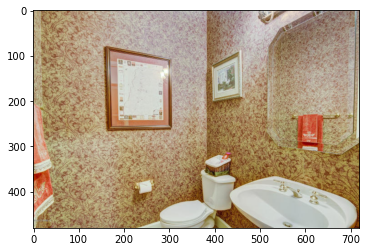

In [58]:
#Rough coding and visulaization

DATADIR = r"C:\Users\KIIT\Downloads\House Images Dataset"
rooms = ['bathroom','bedroom','frontal','kitchen']
CATEGORIES = [([(str(j)+'_'+i) for i in rooms]) for j in range(1,536)]

k = []
for a in CATEGORIES:
    for b in a:
        k.append(b)

for category in CATEGORIES:
    for i in category:
        path = DATADIR
        for img in k:
            im_array = cv2.imread(os.path.join(path, img+'.jpg'))
            img_array = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
            plt.imshow(img_array)
            plt.plot()
            break
        break
    break

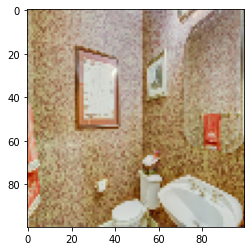

In [59]:
IMG_SIZE = 100

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [60]:
new_array.shape

(100, 100, 3)

In [61]:
#creating image dataset

DATADIR = r"C:\Users\KIIT\Downloads\House Images Dataset"
rooms = ['bathroom','bedroom','frontal','kitchen']
CATEGORIES = [([(str(j)+'_'+i) for i in rooms]) for j in range(1,536)]

k = []
for a in CATEGORIES:
    for b in a:
        k.append(b)

data = []
rooms = []
    
for category in CATEGORIES:
    for i in range(len(category)):
        path = DATADIR
        im_array = cv2.imread(os.path.join(path, category[i]+'.jpg'))
        img_array = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
        new_array = cv2.resize(img_array, (100, 100)) 
        rooms.append(new_array)
    data.append(np.array(rooms))
    rooms.clear()

In [62]:
len(data)

535

In [63]:
a = data.pop(125)
b = data.pop(421)
c = data.pop(395)
d = data.pop(216)
#Removing images with very high prices to reduce model complexity

In [64]:
X = np.array(data)

In [65]:
X = X/255 #Standardization

In [66]:
X[0].shape

(4, 100, 100, 3)

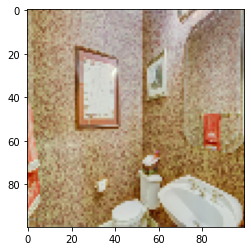

In [67]:
plt.imshow(X[0][0])

In [68]:
bathroom = []
for a in range(X.shape[0]):
    bathroom.append(X[a][0])
    
bedroom = []
for b in range(X.shape[0]):
    bedroom.append(X[b][1])

frontal = []
for c in range(X.shape[0]):
    frontal.append(X[c][2])
    
kitchen = []
for d in range(X.shape[0]):
    kitchen.append(X[d][3])
    
#Fetching different categories from image data

In [69]:
bathroom_train, bathroom_test, y_train, y_test = train_test_split(np.array(bathroom), y, test_size=0.15, random_state=42)
bedroom_train, bedroom_test, y_train, y_test = train_test_split(np.array(bedroom), y, test_size=0.15, random_state=42)
frontal_train, frontal_test, y_train, y_test = train_test_split(np.array(frontal), y, test_size=0.15, random_state=42)
kitchen_train, kitchen_test, y_train, y_test = train_test_split(np.array(kitchen), y, test_size=0.15, random_state=42)

In [71]:
Input_bath = Input(shape=(100,100,3))
Input_bed = Input(shape=(100,100,3))
Input_front = Input(shape=(100,100,3))
Input_kitchen = Input(shape=(100,100,3))

In [186]:
#Creating sequential layers for each of the image category
bath = Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu')(Input_bath)
bath = MaxPooling2D(pool_size=(2,2))(bath)
bath = Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',activation ='relu')(bath)
bath = MaxPooling2D(pool_size=(2,2))(bath)
bath_final = GlobalAveragePooling2D()(bath)

bed = Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu')(Input_bed)
bed = MaxPooling2D(pool_size=(2,2))(bed)
bed = Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',activation ='relu')(bed)
bed = MaxPooling2D(pool_size=(2,2))(bed)
bed_final = GlobalAveragePooling2D()(bed)

front = Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu')(Input_front)
front = MaxPooling2D(pool_size=(2,2))(front)
front = Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',activation ='relu')(front)
front = MaxPooling2D(pool_size=(2,2))(front)
front_final = GlobalAveragePooling2D()(front)

kitchen = Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu')(Input_kitchen)
kitchen = MaxPooling2D(pool_size=(2,2))(kitchen)
kitchen = Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',activation ='relu')(kitchen)
kitchen = MaxPooling2D(pool_size=(2,2))(kitchen)
kitchen_final = GlobalAveragePooling2D()(kitchen)

#combining all inputs 
combined = concatenate([bath_final, bed_final, front_final, kitchen_final])

#adding regularization and creating the final layers for the image category
dropout = Dropout(0.5)(combined)
hidden1 = Dense(64, activation='relu')(dropout)
hidden2 = Dense(32, activation='relu')(hidden1)

#combining both output of the images and the features of the houses
combined2 = concatenate([model1, hidden2])
output = Dense(1, activation='linear')(combined2)

model = Model(inputs=([Input_bath, Input_bed, Input_front, Input_kitchen, input_data]), outputs=output)

In [187]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                          

                                                                                                  
 dense_2 (Dense)                (None, 4)            20          ['input_2[0][0]']                
                                                                                                  
 dense_28 (Dense)               (None, 64)           4160        ['dropout_1[0][0]']              
                                                                                                  
 dense_3 (Dense)                (None, 12)           60          ['dense_2[0][0]']                
                                                                                                  
 dense_29 (Dense)               (None, 32)           2080        ['dense_28[0][0]']               
                                                                                                  
 concatenate_17 (Concatenate)   (None, 44)           0           ['dense_3[0][0]',                
          

In [188]:
callbacks = [
             tf.keras.callbacks.EarlyStopping(patience=60, restore_best_weights=False),
             tf.keras.callbacks.ReduceLROnPlateau(patience=35, factor=0.1)
            ]

#Adding callbacks as it there are multiple inputs and very less number of image data

In [189]:
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

In [190]:
model.fit([bathroom_train, bedroom_train, frontal_train, kitchen_train, data_train], y_train, epochs=200, 
           callbacks=callbacks, batch_size=96, validation_split=0.15)

Epoch 1/200
4/4 [==============================] - 27s 6s/step - loss: 1.2290 - val_loss: 1.4499 - lr: 0.0010
Epoch 2/200
4/4 [==============================] - 20s 5s/step - loss: 1.1983 - val_loss: 1.4082 - lr: 0.0010
Epoch 3/200
4/4 [==============================] - 20s 5s/step - loss: 1.1626 - val_loss: 1.3649 - lr: 0.0010
Epoch 4/200
4/4 [==============================] - 20s 5s/step - loss: 1.1259 - val_loss: 1.3302 - lr: 0.0010
Epoch 5/200
4/4 [==============================] - 20s 5s/step - loss: 1.0557 - val_loss: 1.2870 - lr: 0.0010
Epoch 6/200
4/4 [==============================] - 21s 5s/step - loss: 1.0714 - val_loss: 1.2345 - lr: 0.0010
Epoch 7/200
4/4 [==============================] - 20s 5s/step - loss: 1.0379 - val_loss: 1.2042 - lr: 0.0010
Epoch 8/200
4/4 [==============================] - 20s 5s/step - loss: 0.9755 - val_loss: 1.1688 - lr: 0.0010
Epoch 9/200
4/4 [==============================] - 20s 5s/step - loss: 0.9422 - val_loss: 1.1248 - lr: 0.0010
Epoch 10/2

Epoch 75/200
4/4 [==============================] - 21s 5s/step - loss: 0.4915 - val_loss: 0.5827 - lr: 0.0010
Epoch 76/200
4/4 [==============================] - 21s 5s/step - loss: 0.5143 - val_loss: 0.5352 - lr: 0.0010
Epoch 77/200
4/4 [==============================] - 21s 5s/step - loss: 0.4878 - val_loss: 0.5575 - lr: 0.0010
Epoch 78/200
4/4 [==============================] - 21s 5s/step - loss: 0.4953 - val_loss: 0.5830 - lr: 0.0010
Epoch 79/200
4/4 [==============================] - 22s 6s/step - loss: 0.4862 - val_loss: 0.5313 - lr: 0.0010
Epoch 80/200
4/4 [==============================] - 20s 5s/step - loss: 0.4785 - val_loss: 0.5457 - lr: 0.0010
Epoch 81/200
4/4 [==============================] - 21s 5s/step - loss: 0.4873 - val_loss: 0.5513 - lr: 0.0010
Epoch 82/200
4/4 [==============================] - 21s 5s/step - loss: 0.4876 - val_loss: 0.5241 - lr: 0.0010
Epoch 83/200
4/4 [==============================] - 20s 5s/step - loss: 0.4928 - val_loss: 0.5588 - lr: 0.0010
E

4/4 [==============================] - 20s 5s/step - loss: 0.4293 - val_loss: 0.5229 - lr: 1.0000e-04
Epoch 149/200
4/4 [==============================] - 20s 5s/step - loss: 0.4213 - val_loss: 0.5200 - lr: 1.0000e-04
Epoch 150/200
4/4 [==============================] - 20s 5s/step - loss: 0.4198 - val_loss: 0.5198 - lr: 1.0000e-04
Epoch 151/200
4/4 [==============================] - 20s 5s/step - loss: 0.4326 - val_loss: 0.5249 - lr: 1.0000e-04
Epoch 152/200
4/4 [==============================] - 19s 5s/step - loss: 0.4299 - val_loss: 0.5261 - lr: 1.0000e-04
Epoch 153/200
4/4 [==============================] - 20s 5s/step - loss: 0.4292 - val_loss: 0.5284 - lr: 1.0000e-04
Epoch 154/200
4/4 [==============================] - 21s 5s/step - loss: 0.4463 - val_loss: 0.5317 - lr: 1.0000e-04
Epoch 155/200
4/4 [==============================] - 21s 5s/step - loss: 0.4289 - val_loss: 0.5274 - lr: 1.0000e-04
Epoch 156/200
4/4 [==============================] - 23s 6s/step - loss: 0.4312 - val_

In [192]:
mean_squared_error(y_test, model.predict(x = ([bathroom_test, bedroom_test, frontal_test, kitchen_test],data_test)))

0.8614626583431239

In [198]:
mean_absolute_percentage_error(scaler.inverse_transform(y_test), 
            scaler.inverse_transform(model.predict(x = ([bathroom_test, bedroom_test, frontal_test, kitchen_test],data_test))))

0.7879628948427181

In [202]:
#What else can be done to improve the model
#Image Augmentation
#Keras hyperparamter tuning (not done due to space and time complexities)
# A different approach to multi-input problems